In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt


df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

# RFM Table Creation Function
def create_rfm(dataframe):

    # Calculate Total Orders and Value
    dataframe["order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["customer_value_total"] = dataframe["customer_value_total_ever_online"] + dataframe["customer_value_total_ever_offline"]
    date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # Set Analysis Date and Calculate RFM Metrics
    dataframe["last_order_date"].max()
    analysis_date = dt.datetime(2021, 6, 1)

    rfm = pd.DataFrame()
    rfm["customer_id"] = dataframe["master_id"]
    rfm["recency"] = (analysis_date - dataframe["last_order_date"]).dt.days
    rfm["frequency"] = dataframe["order_num_total"]
    rfm["monetary"] = dataframe["customer_value_total"]

    # Calculate RFM Scores
    rfm["recency_score"] = pd.qcut(rfm["recency"], 5, labels = [5, 4, 3, 2, 1])
    rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
    rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels = [1, 2, 3, 4, 5])

    rfm["RF_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))
    rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str))

    # Assign Segments
    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_Risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    rfm["segment"] = rfm["RF_SCORE"].replace(seg_map, regex = True)

    return rfm[["customer_id", "recency", "frequency", "monetary", "RF_SCORE", "RFM_SCORE", "segment"]]

# Create RFM Table
rfm_df = create_rfm(df)

In [3]:
rfm_df

,customer_id,recency,frequency,monetary,RF_SCORE,RFM_SCORE,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,95,5.0,939.37,34,344,loyal_customers
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,105,21.0,2013.55,35,355,loyal_customers
2,69b69676-1a40-11ea-941b-000d3a38a36f,186,5.0,585.32,24,243,at_Risk
3,1854e56c-491f-11eb-806e-000d3a38a36f,135,2.0,121.97,31,311,about_to_sleep
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,86,2.0,209.98,31,311,about_to_sleep
...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,331,3.0,401.96,13,132,at_Risk
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,161,2.0,390.47,22,222,hibernating
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,8,3.0,632.94,53,533,potential_loyalists
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,108,6.0,1009.77,34,344,loyal_customers


In [4]:
visualize = rfm_df[["segment"]].value_counts()

In [5]:
visualize

segment            
hibernating            3604
loyal_customers        3361
at_Risk                3131
potential_loyalists    2938
champions              1932
about_to_sleep         1629
cant_loose             1200
need_attention          823
new_customers           680
promising               647
Name: count, dtype: int64

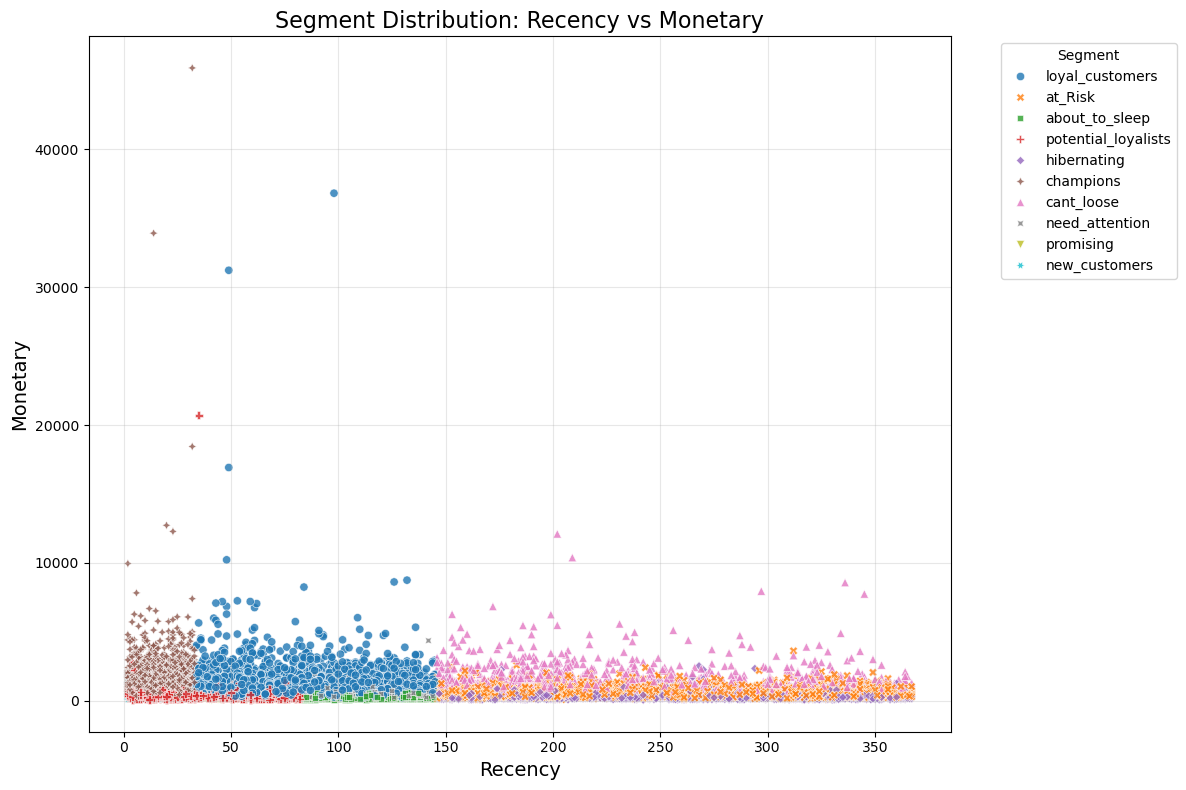

In [ ]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Create a scatter plot for all segments
sns.scatterplot(
    data=rfm_df,
    x='recency',
    y='monetary',
    hue='segment',
    style='segment',
    palette='tab10',
    alpha=0.8
)

# Add labels and title
plt.title('Segment Distribution: Recency vs Monetary', fontsize=16)
plt.xlabel('Recency', fontsize=14)
plt.ylabel('Monetary', fontsize=14)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


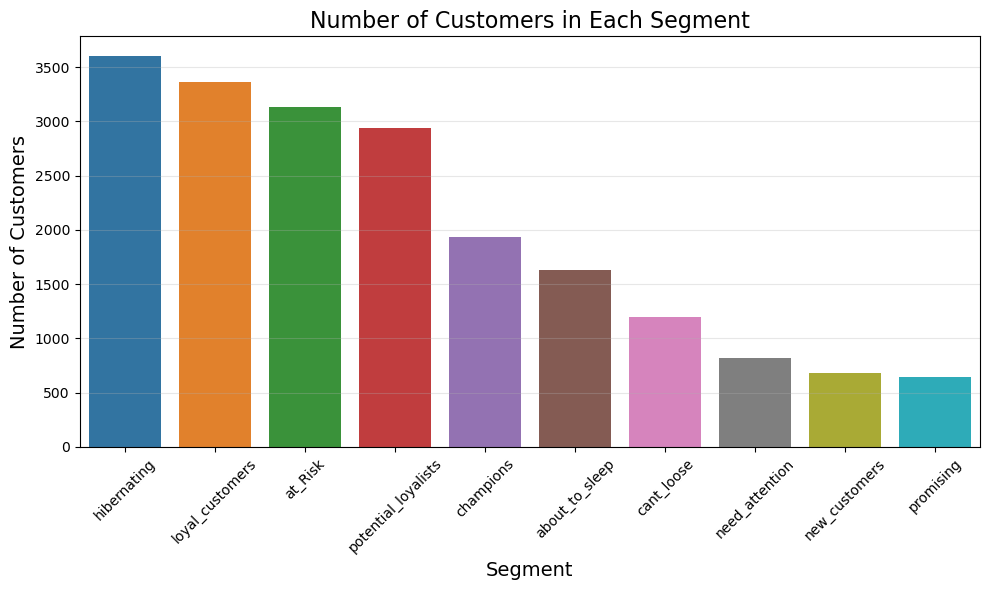

In [ ]:
segment_counts = rfm_df["segment"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=segment_counts.index,
    y=segment_counts.values,
    hue=segment_counts.index,        
    palette='tab10',
    dodge=False,
    legend=False
)

plt.title("Number of Customers in Each Segment", fontsize=16)
plt.xlabel("Segment", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

(-1.0999984154324782,
 1.0999987449721833,
 -1.0999997487746396,
 1.0999999880241582)

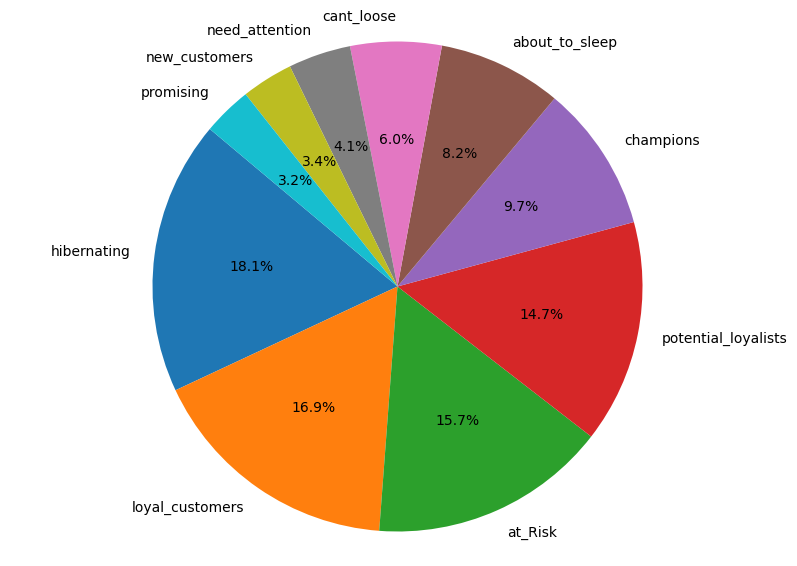

In [27]:
segment_counts = rfm_df["segment"].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(
    segment_counts.values,
    labels=segment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab10.colors
)

plt.axis('equal')  # Daire şeklinde olsun

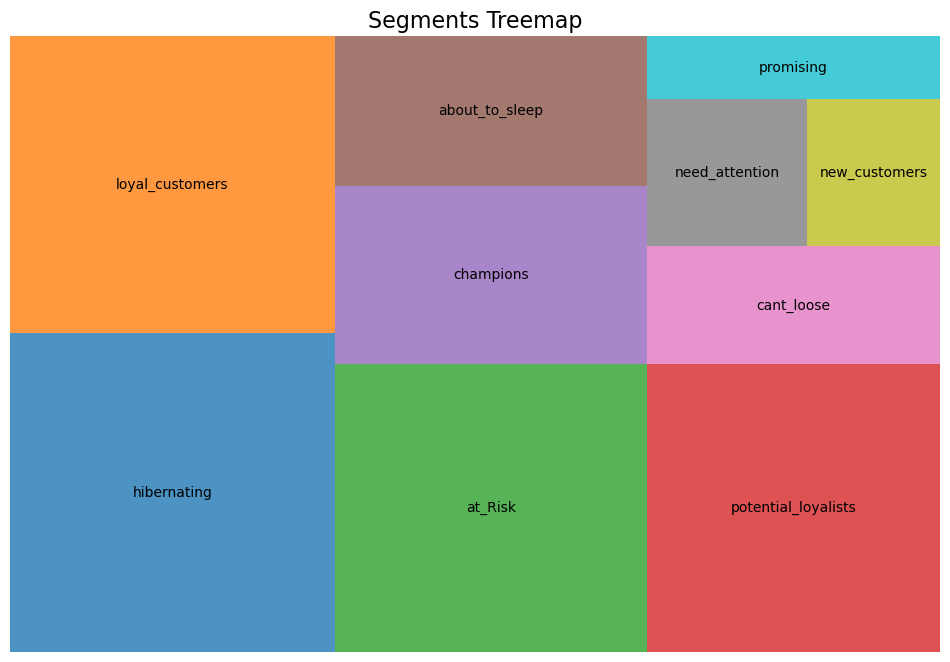

In [ ]:
# Treemap için squarify kütüphanesi gerekli: pip install squarify
import squarify

segment_counts = rfm_df["segment"].value_counts()

plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=segment_counts.values,
    label=segment_counts.index,
    color=plt.cm.tab10.colors,
    alpha=0.8
)
plt.title("Segments Treemap", fontsize=16)
plt.axis('off')
plt.show()